In [1]:
import time
import numpy as np
from numba import njit, prange
from SALib.sample import saltelli
from SALib.analyze import sobol

np.random.seed(42)
a, b = np.random.sample(size=2)
print(a,b)

problem = {
    'num_vars' : 3,
    'names' : ['x1', 'x2', 'x3'],
    'bounds' : [[-2*np.pi, 2*np.pi],
                [-2*np.pi, 2*np.pi],
                [-2*np.pi, 2*np.pi]
               ]
}

0.3745401188473625 0.9507143064099162


Первый проход:
+ Сэмплирование как есть
+ evaluate_model не расспаралелено
+ sobol.analyze не расспаралелено

samples generated in 5.117434978485107 seconds
model evaluated in 5.924739122390747 seconds
SA took 4.841145038604736 seconds
Overall time = 15.886384010314941 seconds
[9.83737892e-05 4.22938263e-06 9.03451318e-02]
[0.90968766 0.90963752 0.09034513]
x1-x2: 0.9094613526904445
x1-x3: -6.962218545893128e-05
x2-x3: -8.995909713094274e-06


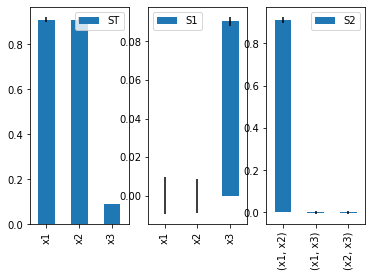

In [2]:
n = 2**17

def evaluate_model(x):
    return a * np.sin(x[2]) ** 2 * np.cos(x[2]) + b * np.sin(x[0])**3 * np.cos(x[1])**3

### Sampling
START = time.time()
start = time.time()
param_values = saltelli.sample(problem, n)
print(f"samples generated in {(time.time() - start)} seconds")
Y = np.zeros([param_values.shape[0]])

#Evaluation
start = time.time()
for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

print(f"model evaluated in {(time.time() - start)} seconds")

# Analyze
start = time.time()
Si = sobol.analyze(problem, Y)

print(f"SA took {(time.time() - start)} seconds")
print(f"Overall time = {time.time() - START} seconds")

#Solution
print(Si['S1'])
print(Si['ST'])
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

Si.plot();

перепишем функцию evaluate model через numba для паралелизации

Второй проход:
+ Сэмплирование как есть
+ evaluate_model расспаралелено
+ sobol.analyze не расспаралелено

samples generated in 5.096502065658569 seconds
model evaluated in 0.7096209526062012 seconds
SA took 4.933300971984863 seconds
Overall time = 10.744753122329712 seconds
[9.83737892e-05 4.22938263e-06 9.03451318e-02]
[0.90968766 0.90963752 0.09034513]
x1-x2: 0.9094613526904448
x1-x3: -6.962218545893128e-05
x2-x3: -8.995909713094274e-06


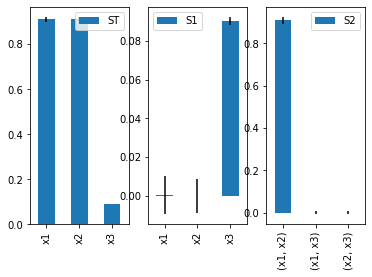

In [3]:
n = 2**17

@njit
def evaluate_model(x):
    return a * np.sin(x[2]) ** 2 * np.cos(x[2]) + b * np.sin(x[0])**3 * np.cos(x[1])**3

### Sampling
START = time.time()
start = time.time()
param_values = saltelli.sample(problem, n)
print(f"samples generated in {(time.time() - start)} seconds")
Y = np.zeros([param_values.shape[0]])

#Evaluation
start = time.time()
for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

print(f"model evaluated in {(time.time() - start)} seconds")

# Analyze
start = time.time()
Si = sobol.analyze(problem, Y)

print(f"SA took {(time.time() - start)} seconds")

print(f"Overall time = {time.time() - START} seconds")

#Solution
print(Si['S1'])
print(Si['ST'])
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

Si.plot();

Видим что время на evaluate_model сократилось почти в 10 раз!

попробуем расспаралелить sobol.analyze с помощью флага в parallel = True

Третий проход:
+ Сэмплирование как есть
+ evaluate_model расспаралелено
+ sobol.analyze расспаралелено

samples generated in 5.138713121414185 seconds
model evaluated in 0.5880441665649414 seconds
SA took 5.488387107849121 seconds
Overall time = 11.218425750732422 seconds
[9.83737892e-05 4.22938263e-06 9.03451318e-02]
[0.90968766 0.90963752 0.09034513]
x1-x2: 0.9094613526904448
x1-x3: -6.962218545893128e-05
x2-x3: -8.995909713094274e-06


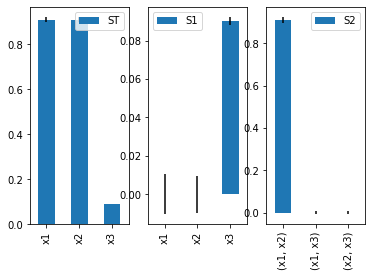

In [4]:
@njit
def evaluate_model(x):
    return a * np.sin(x[2]) ** 2 * np.cos(x[2]) + b * np.sin(x[0])**3 * np.cos(x[1])**3

n = 2**17

### Sampling
START = time.time()
start = time.time()
param_values = saltelli.sample(problem, n)
print(f"samples generated in {(time.time() - start)} seconds")
Y = np.zeros([param_values.shape[0]])

#Evaluation
start = time.time()
for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

print(f"model evaluated in {(time.time() - start)} seconds")

# Analyze
start = time.time()
Si = sobol.analyze(problem, Y, parallel=True, n_processors = 2)

print(f"SA took {(time.time() - start)} seconds")

print(f"Overall time = {time.time() - START} seconds")

#Solution
print(Si['S1'])
print(Si['ST'])
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

Si.plot();

время на sobol.analyze уменьшилось, но не значительно. Увеличивать количество процессоров более чем на 2 на моем железе - только усугубляет проблему, так как требуется дополнительное время на выделение работы на процессоры, из-за чего на n_processors > 2, только ухудшить ситуацию.

P.S. - как оказалось даже не всегда с n_processors=2 время становится быстрее.

Четвертый проход:
+ Сэмплирование расспаралелено
+ evaluate_model расспаралелено
+ sobol.analyze расспаралелено

In [5]:
import multiprocessing as mp
def sample_func_classic(args):
    problem, n, i = args
    return saltelli.sample(problem, n, i*n)

num_workers = 2
result = []
with mp.Pool(num_workers) as pool:
    result = pool.map(sample_func_classic, [(problem, n // num_workers, i+1) for i in range(num_workers)])

In [6]:
result

[array([[-6.28289769e+00, -9.58737992e-05, -3.51760969e-01],
        [ 4.88620818e+00, -9.58737992e-05, -3.51760969e-01],
        [-6.28289769e+00, -1.46102083e+00, -3.51760969e-01],
        ...,
        [-4.68487320e+00,  9.58737992e-05, -2.74879770e+00],
        [-4.68487320e+00, -4.58823241e+00,  5.12972763e+00],
        [-4.68487320e+00, -4.58823241e+00, -2.74879770e+00]]),
 array([[-6.28289769e+00, -9.58737992e-05, -3.51760969e-01],
        [ 4.88620818e+00, -9.58737992e-05, -3.51760969e-01],
        [-6.28289769e+00, -1.46102083e+00, -3.51760969e-01],
        ...,
        [-4.68487320e+00,  9.58737992e-05, -2.74879770e+00],
        [-4.68487320e+00, -4.58823241e+00,  5.12972763e+00],
        [-4.68487320e+00, -4.58823241e+00, -2.74879770e+00]])]

видимо не получится расспаралелить сэмплирование, потому что saltelli.sample генерирует последовательность последовательно и детерминировано. Хотя и быстрее :)